<a href="https://colab.research.google.com/github/sooonsyk/24-2-ml-project/blob/main/Mobilenetv2_sooyeon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Alzheimer MRI Disease Classification**

## **Mobilenetv2**

In [ ]:
!pip install datasets

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/15] - Train Loss: 0.7505, Train Acc: 0.6691, Test Loss: 0.6535, Test Acc: 0.7180
Epoch [2/15] - Train Loss: 0.3122, Train Acc: 0.8736, Test Loss: 0.4082, Test Acc: 0.8406
Epoch [3/15] - Train Loss: 0.1323, Train Acc: 0.9533, Test Loss: 0.2349, Test Acc: 0.9141
Epoch [4/15] - Train Loss: 0.0640, Train Acc: 0.9777, Test Loss: 0.3599, Test Acc: 0.8930
Epoch [5/15] - Train Loss: 0.0729, Train Acc: 0.9748, Test Loss: 0.2259, Test Acc: 0.9258
Epoch [6/15] - Train Loss: 0.0566, Train Acc: 0.9803, Test Loss: 0.2196, Test Acc: 0.9227
Epoch [7/15] - Train Loss: 0.0588, Train Acc: 0.9807, Test Loss: 0.1605, Test Acc: 0.9406
Epoch [8/15] - Train Loss: 0.0281, Train Acc: 0.9910, Test Loss: 0.2972, Test Acc: 0.9227
Epoch [9/15] - Train Loss: 0.0451, Train Acc: 0.9842, Test Loss: 0.1692, Test Acc: 0.9508
Epoch [10/15] - Train Loss: 0.0535, Train Acc: 0.9816, Test Loss: 0.3083, Test Acc: 0.8961
Epoch [11/15] - Train Loss: 0.0318, Train Acc: 0.9877, Test Loss: 0.1795, Test Acc: 0.9383
Epoch [1

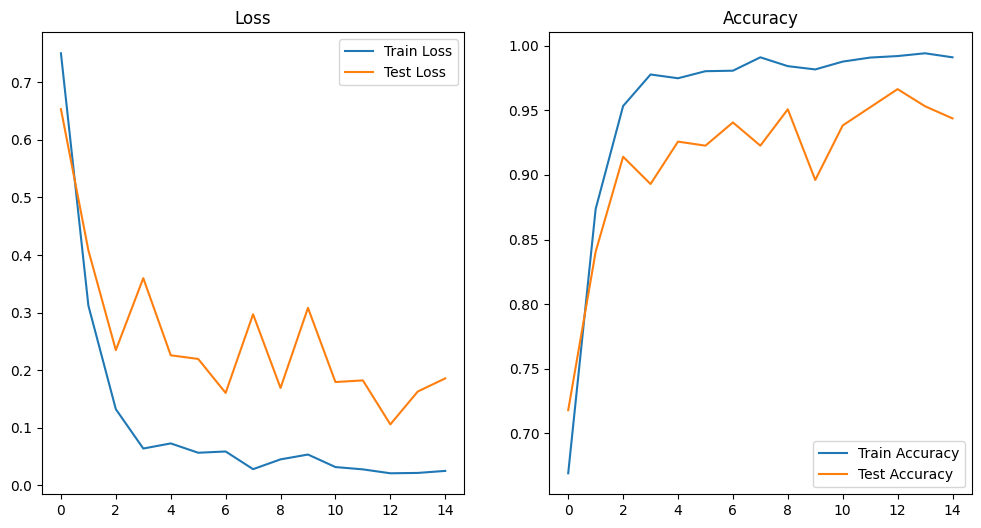

F1-Score: 0.9433, Accuracy: 0.9437


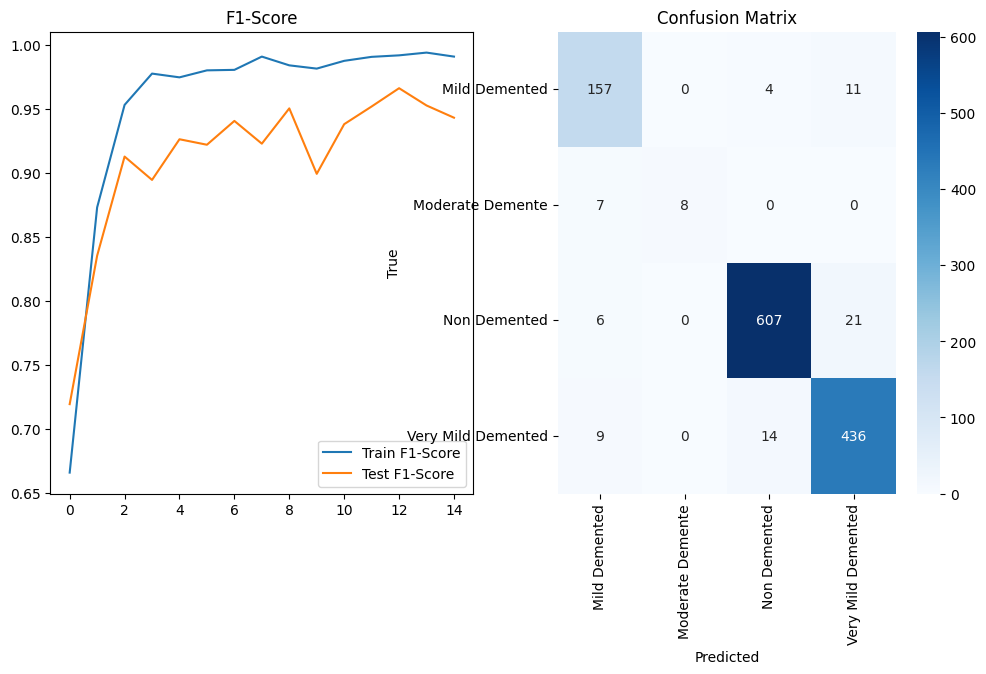

In [5]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Load Dataset
train_dataset = load_dataset('Falah/Alzheimer_MRI', split='train')
test_dataset = load_dataset('Falah/Alzheimer_MRI', split='test')

# 2. Define Transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize all images to 128x128
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()           # Convert to PyTorch Tensor
])

# 3. Define PyTorch Dataset
class AlzheimerMRIDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Access row
        item = self.dataset[idx]
        # Load image
        image = item['image']
        # Apply transformation if defined
        if self.transform:
            image = self.transform(image)
        # Load label
        label = item['label']

        return image, label

# 4. Create PyTorch Dataset
train_dataset = AlzheimerMRIDataset(train_dataset, transform=transform)
test_dataset = AlzheimerMRIDataset(test_dataset, transform=transform)

# 5. Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 6. Load Pretrained MobileNetV2 Model
model = models.mobilenet_v2(pretrained=True)

# 7. Modify the final classifier layer for the dataset (number of classes)
num_classes = len(set(train_dataset.dataset['label']))  # Assuming the dataset labels are integers
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# 8. Move the model to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 9. Loss function and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-3)

# 10. Training Loop
num_epochs = 15
train_loss_list, test_loss_list = [], []
train_acc_list, test_acc_list = [], []
train_f1_list, test_f1_list = [], []

for epoch in range(num_epochs):
    model.train()
    total_loss, correct_train, total_train = 0, 0, 0
    y_true_train, y_pred_train = [], []

    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)

        # Forward pass
        y_pred = model(x)

        # Calculate loss
        loss = loss_function(y_pred, y)
        total_loss += loss.item() * x.size(0)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, preds = torch.max(y_pred, 1)
        correct_train += torch.sum(preds == y).item()
        total_train += y.size(0)

        # Collect true and predicted labels for F1-score
        y_true_train.extend(y.cpu().numpy())
        y_pred_train.extend(preds.cpu().numpy())

    # Compute average loss and accuracy
    avg_train_loss = total_loss / total_train
    train_accuracy = correct_train / total_train
    train_f1 = f1_score(y_true_train, y_pred_train, average='weighted')
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(train_accuracy)
    train_f1_list.append(train_f1)

    # Evaluation on the test set
    model.eval()
    total_loss, correct_test, total_test = 0, 0, 0
    y_true_test, y_pred_test = [], []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)

            # Calculate loss
            loss = loss_function(y_pred, y)
            total_loss += loss.item() * x.size(0)

            # Calculate accuracy
            _, preds = torch.max(y_pred, 1)
            correct_test += torch.sum(preds == y).item()
            total_test += y.size(0)

            # Collect true and predicted labels for F1-score
            y_true_test.extend(y.cpu().numpy())
            y_pred_test.extend(preds.cpu().numpy())

    avg_test_loss = total_loss / total_test
    test_accuracy = correct_test / total_test
    test_f1 = f1_score(y_true_test, y_pred_test, average='weighted')
    test_loss_list.append(avg_test_loss)
    test_acc_list.append(test_accuracy)
    test_f1_list.append(test_f1)

    print(f"Epoch [{epoch + 1}/{num_epochs}] - "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.4f}")

# 11. Plot Training and Test Loss/Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(test_acc_list, label='Test Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

# 12. Calculate F1-Score and Confusion Matrix
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_true.extend(y.cpu().numpy())
        outputs = model(x)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().numpy())

# F1-Score and Accuracy
f1 = f1_score(y_true, y_pred, average='weighted')
acc = accuracy_score(y_true, y_pred)
print(f"F1-Score: {f1:.4f}, Accuracy: {acc:.4f}")

# Confusion Matrix
label_names = ["Mild Demented", "Moderate Demente", "Non Demented", "Very Mild Demented"]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_f1_list, label='Train F1-Score')
plt.plot(test_f1_list, label='Test F1-Score')
plt.legend()
plt.title('F1-Score')

plt.subplot(1, 2, 2)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



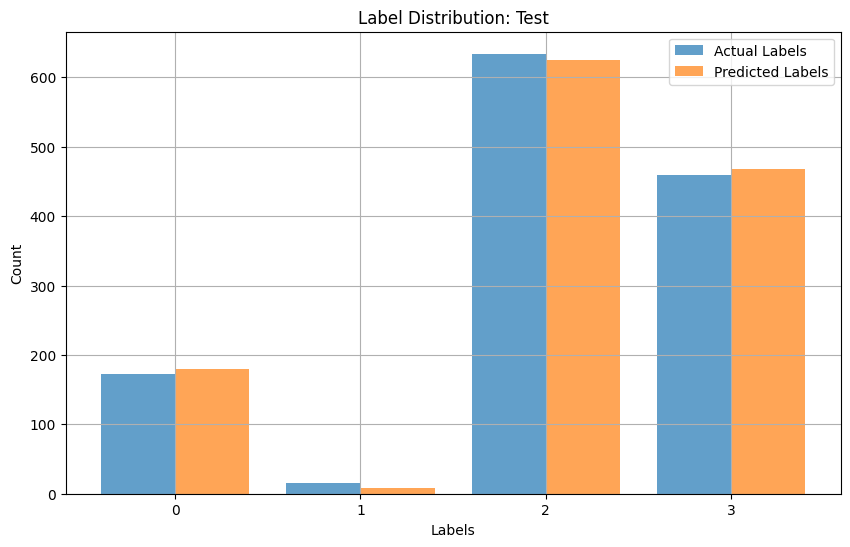

In [8]:
from collections import Counter

def plot_label_distribution(labels, preds, title):
    actual_counts = Counter(labels)
    predicted_counts = Counter(preds)
    all_classes = sorted(set(labels))
    actual_distribution = [actual_counts[cls] for cls in all_classes]
    predicted_distribution = [predicted_counts[cls] for cls in all_classes]

    plt.figure(figsize=(10, 6))
    bar_width = 0.4
    indices = np.arange(len(all_classes))
    plt.bar(indices, actual_distribution, width=bar_width, label="Actual Labels", alpha=0.7)
    plt.bar(indices + bar_width, predicted_distribution, width=bar_width, label="Predicted Labels", alpha=0.7)
    plt.title(title)
    plt.xlabel("Labels")
    plt.ylabel("Count")
    plt.xticks(indices + bar_width / 2, all_classes)
    plt.legend()
    plt.grid(True)
    plt.show()

# Test Label Distribution
plot_label_distribution(y_true, y_pred, "Label Distribution: Test")